In [140]:
import configparser
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV


In [141]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

BOSTON_PATH = config['data']['boston_path']
SEATTLE_PATH = config['data']['seattle_path']

## READ CSV FILES

In [142]:
df = pd.read_csv(BOSTON_PATH)

In [143]:
print("Boston AirBnB has {} rows and {} columns".format(df.shape[0], df.shape[1]))

Boston AirBnB has 3585 rows and 95 columns


## Basic EDA

## Check null data

Using msno to check missing values

<Axes: >

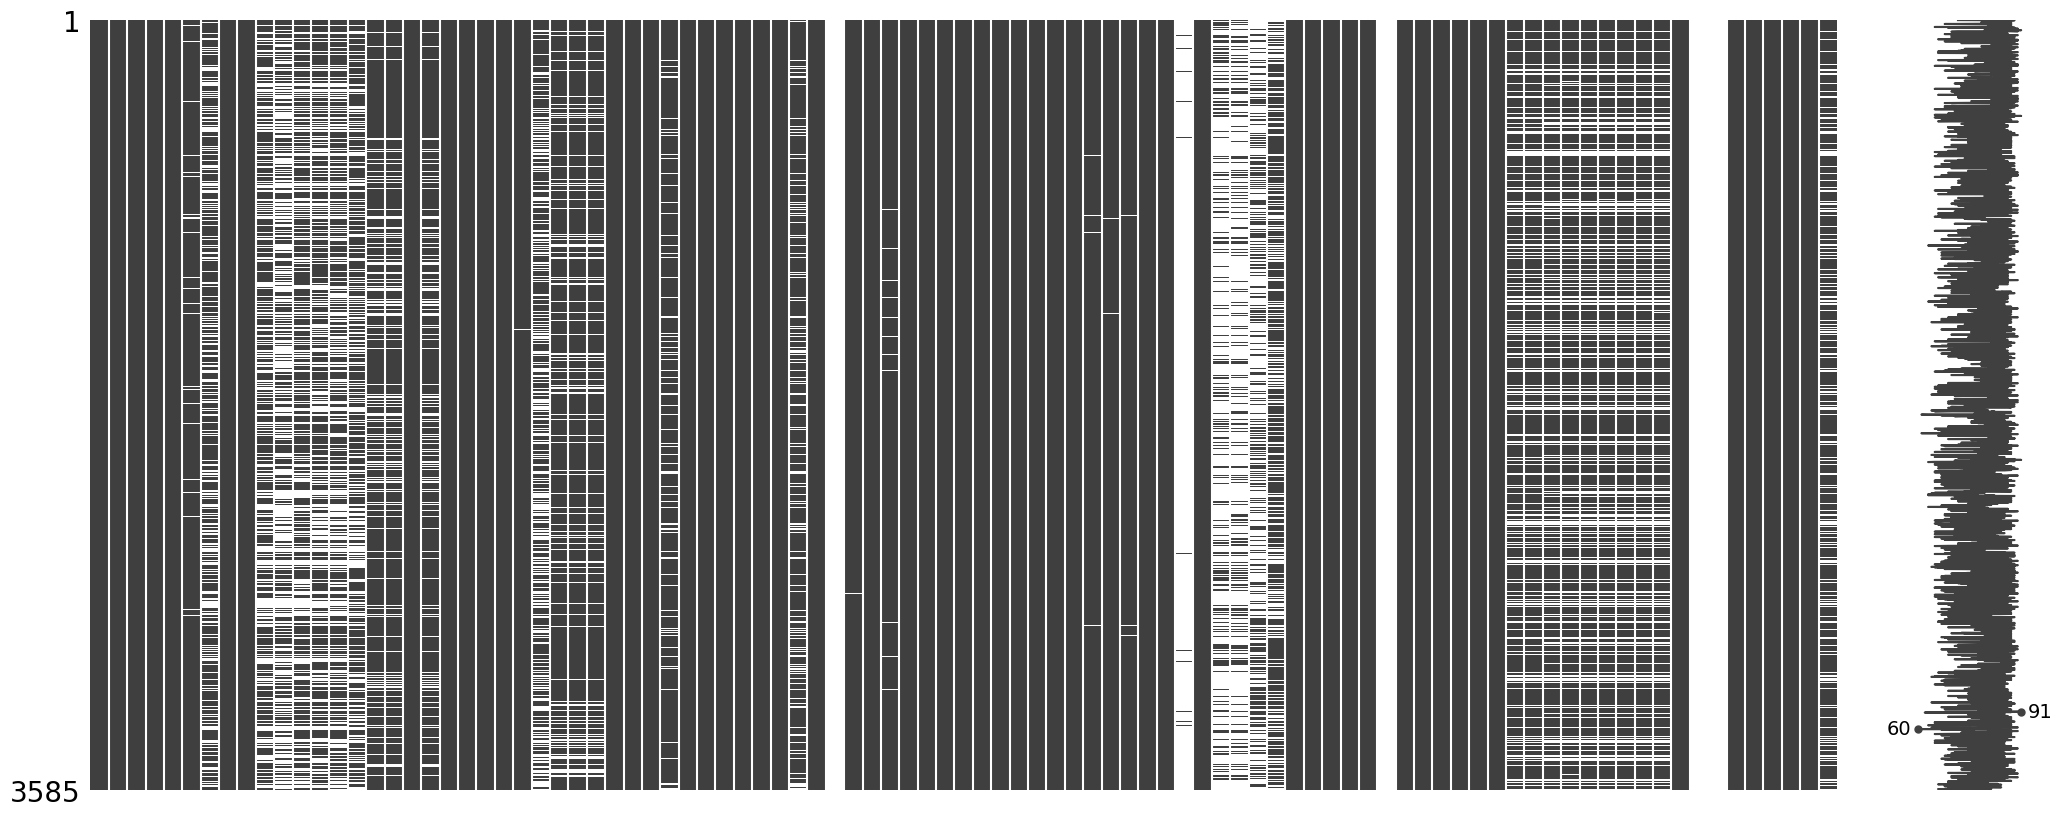

In [146]:
msno.matrix(df)

<Axes: >

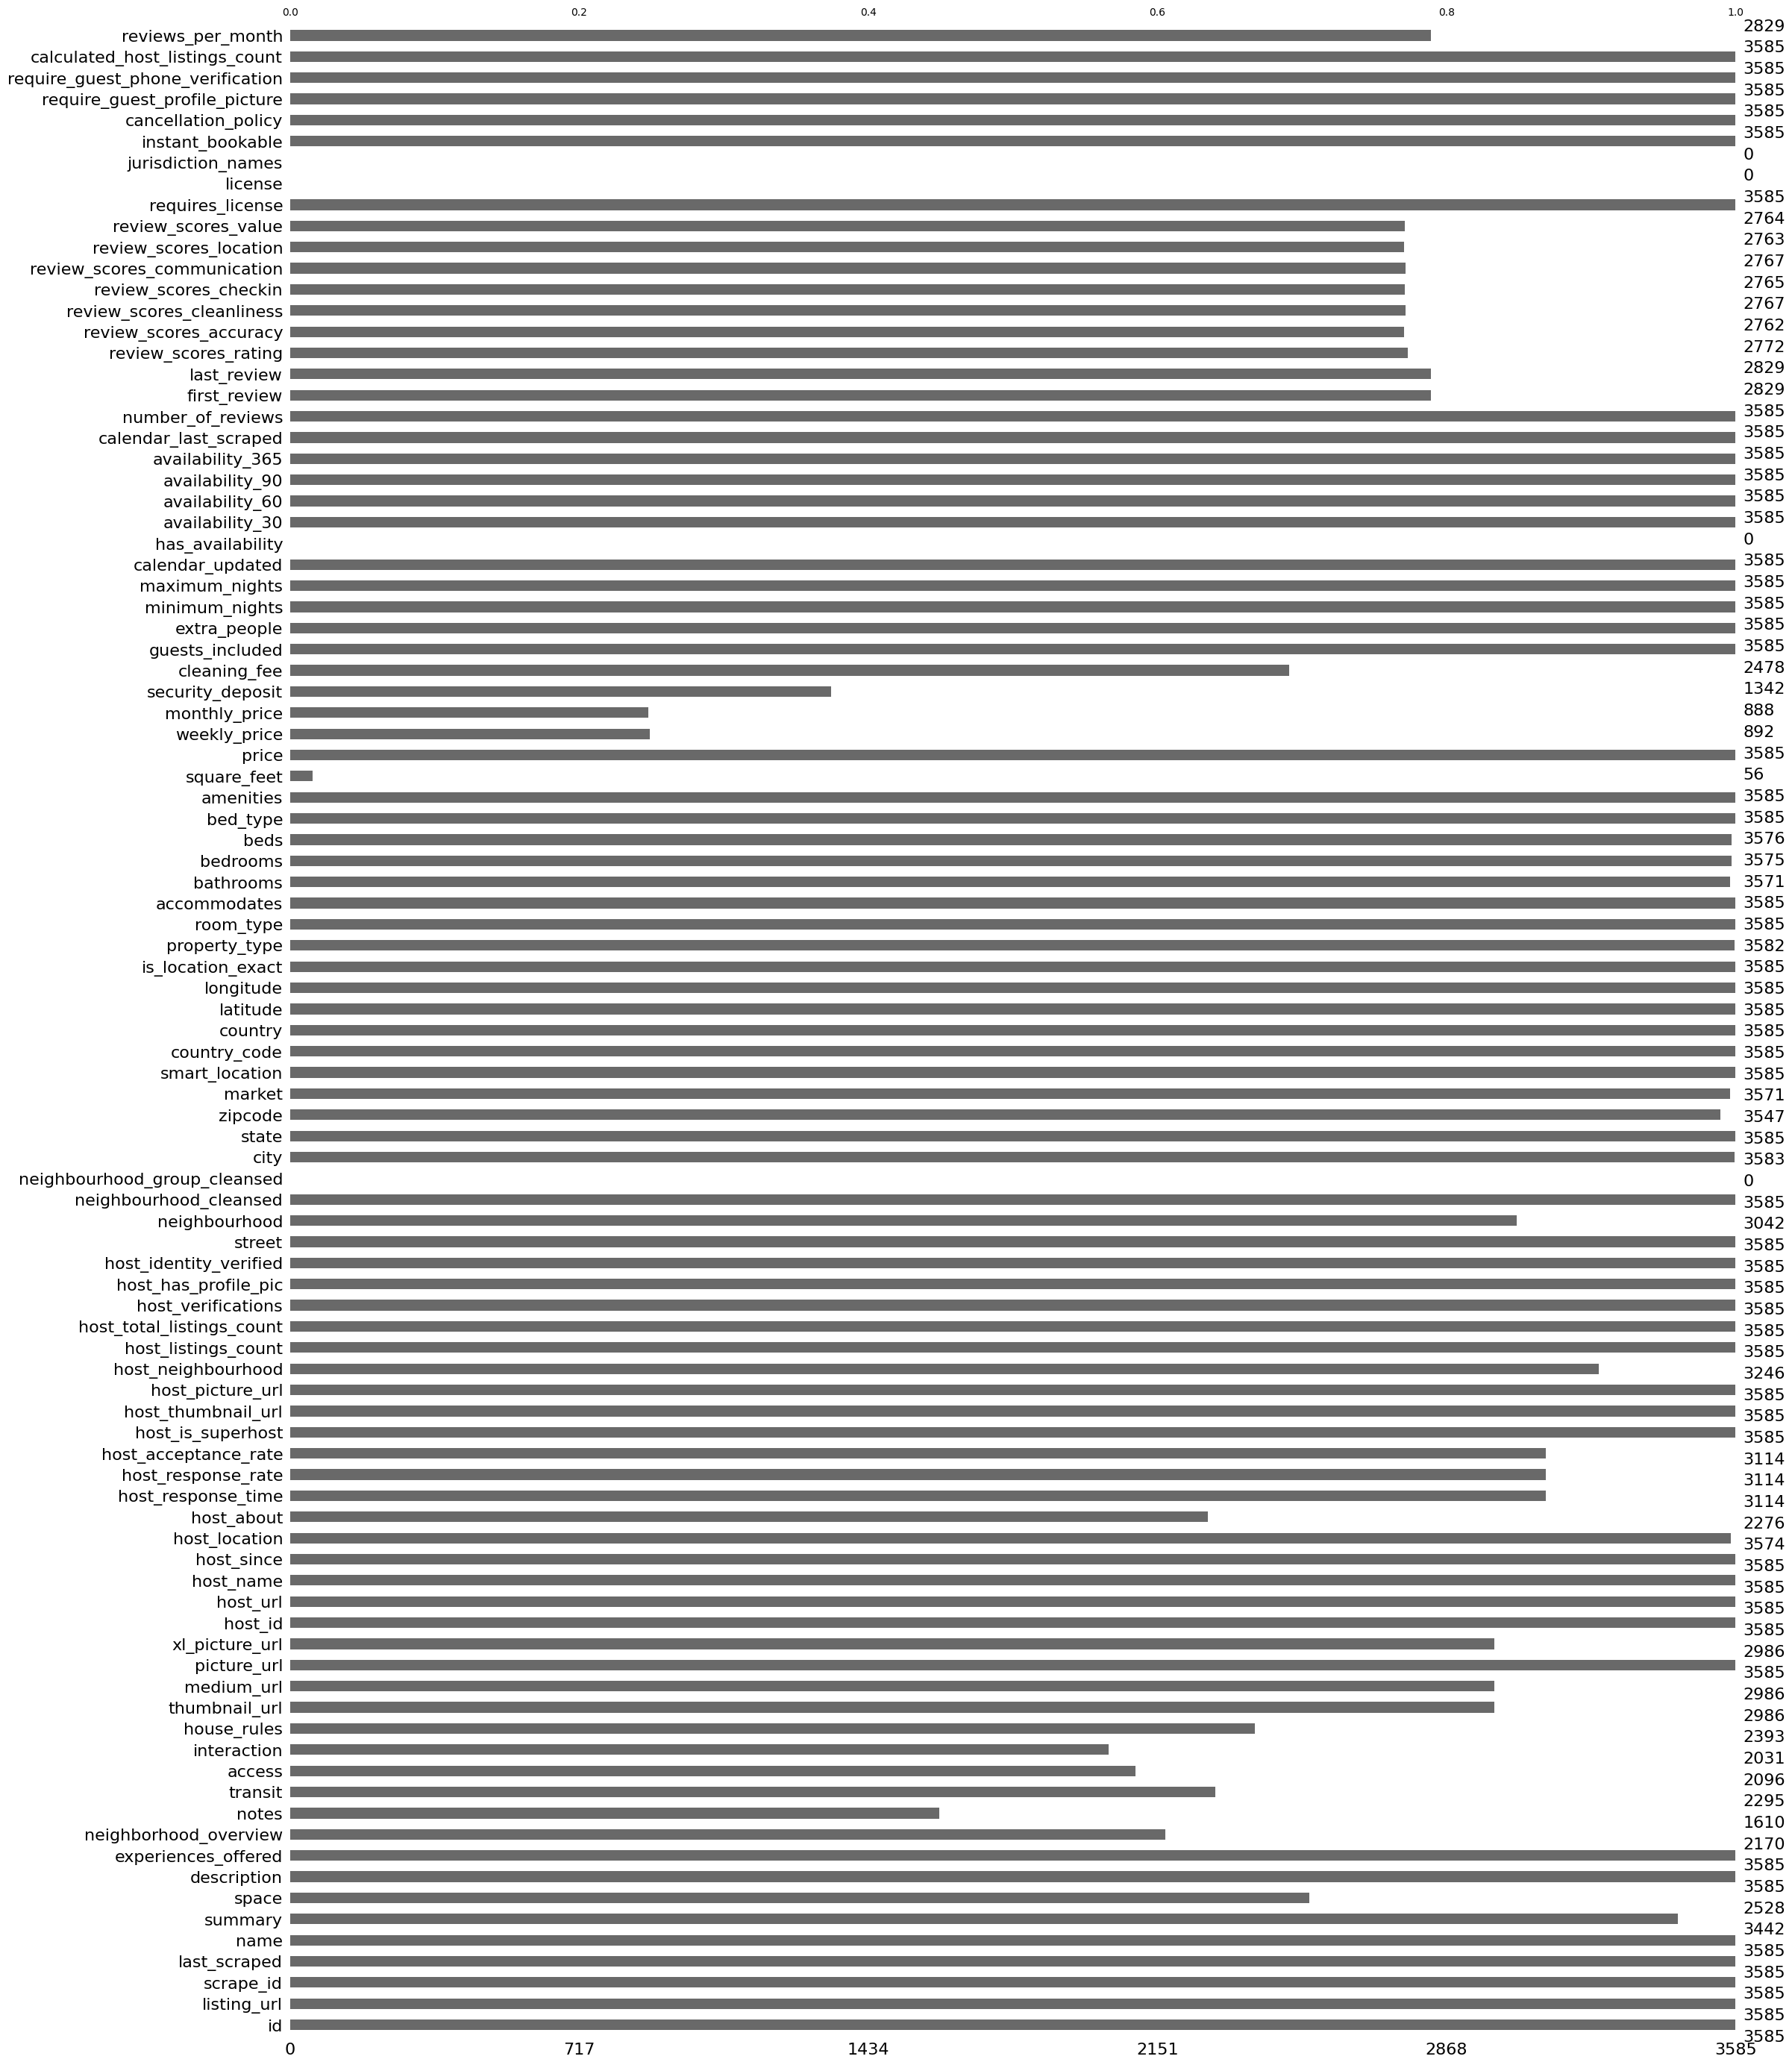

In [147]:
msno.bar(df)

## Dealing with price col

Convert those price columns to numeric type: $500 -> 500

In [148]:
price_col = ['price', 'security_deposit', 'cleaning_fee', 'extra_people']

In [149]:
for col in price_col:
    try:
        df[col] = pd.to_numeric(df[col].str.replace('$', '').str.replace(',', ''), errors='coerce')
    except:
        print("Can't convert column", col)

<Axes: >

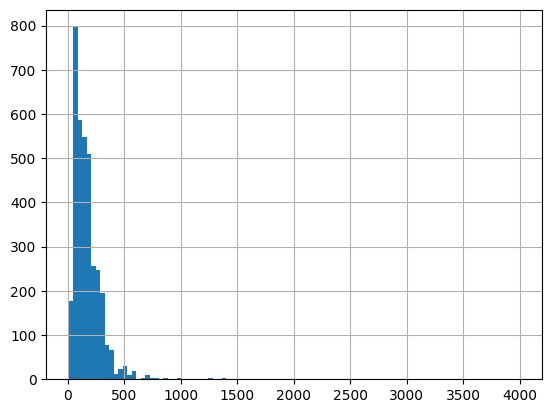

In [150]:
df['price'].hist(bins=100)

Most of the price is lower than 1000 so I will remove the outliers with price higher than 1000.

In [151]:
# Filter out price that larger than 1000$
df = df[df['price'] < 1000]

<Axes: >

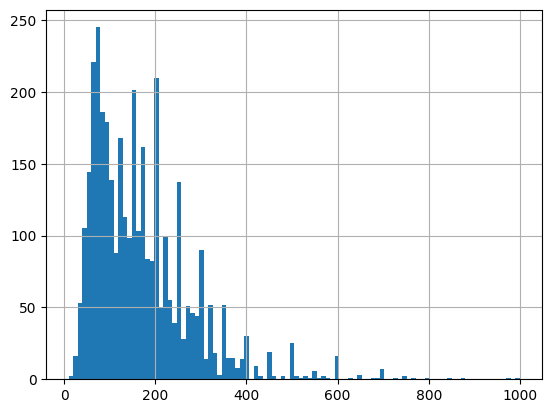

In [152]:
df['price'].hist(bins=100)

## fill missing data

I think these columns will work well for the model because they are highly correlated with the price and they are also easy to understand and interpret.

In [153]:
useful_col = ['longitude', 'latitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [154]:
df = df[useful_col]

Using msno to check missing values

<Axes: >

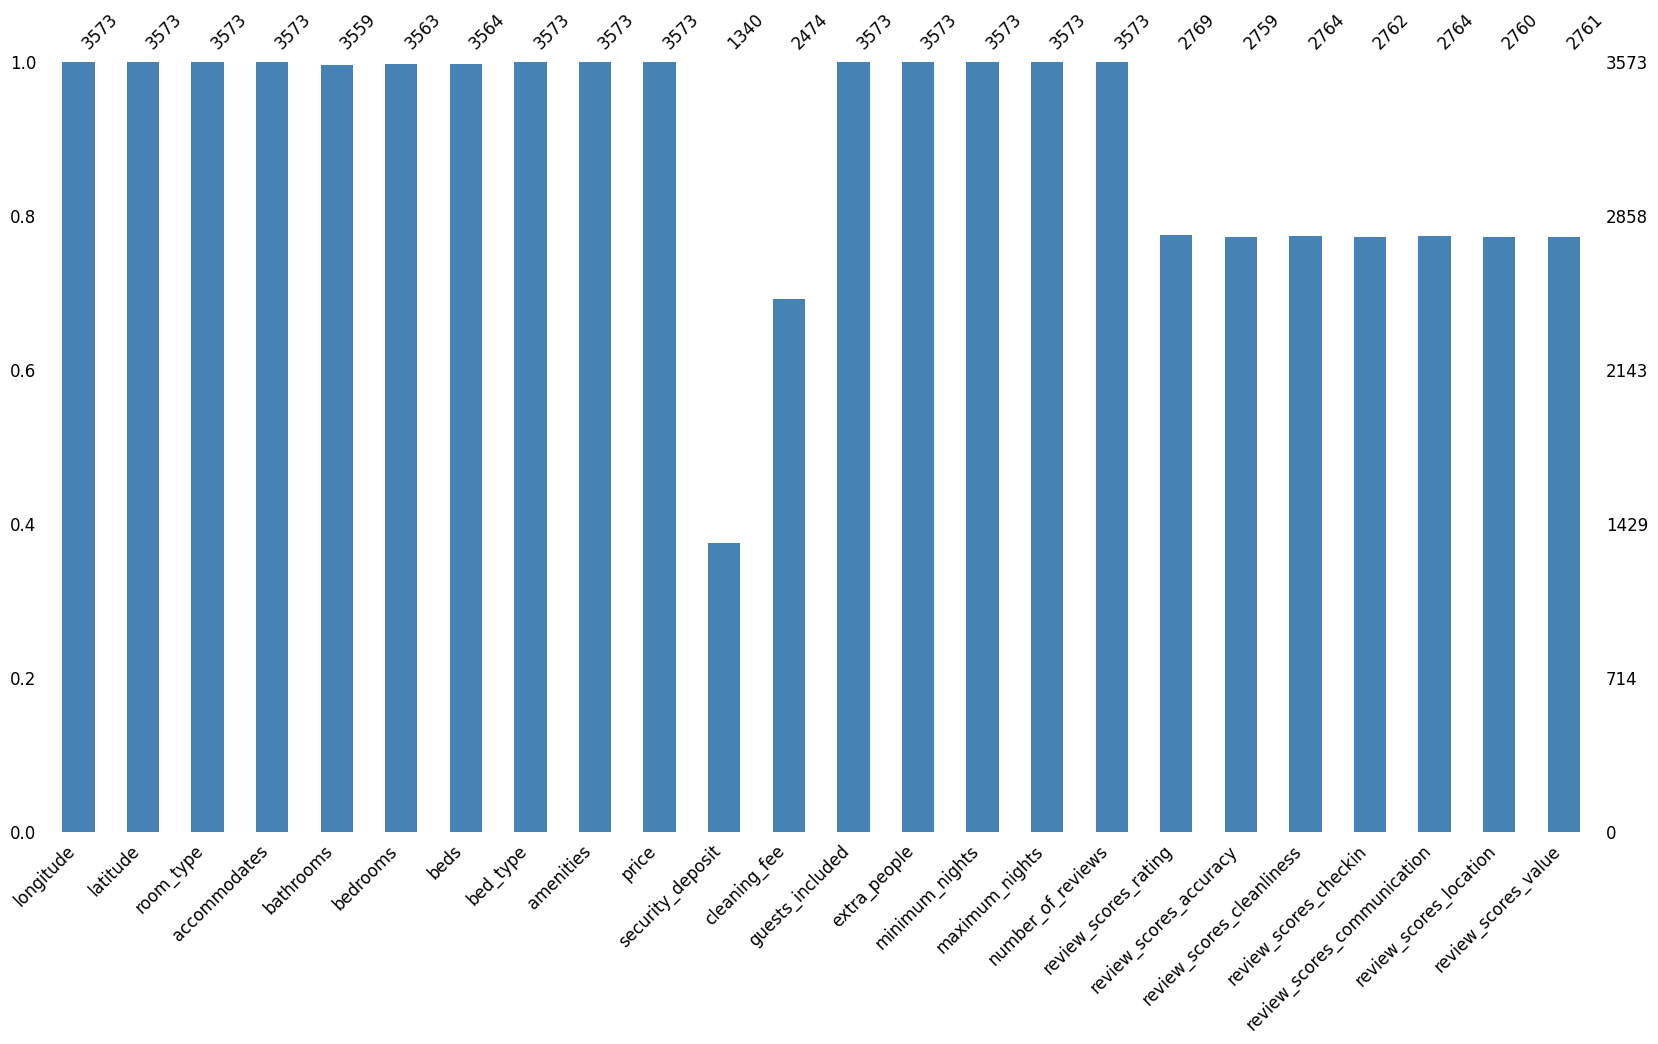

In [157]:
msno.bar(df, figsize=(20, 10), fontsize=12, color='steelblue')

Dealing with these missing columns

In [158]:
# List null columns
# List columns with null values

null_col = []
for col in df.columns:
    if df[col].isnull().any():
        null_col.append(col)
print(null_col)

['bathrooms', 'bedrooms', 'beds', 'security_deposit', 'cleaning_fee', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']


In [159]:
df_encode = pd.get_dummies(df)

Fill median bathrooms and beds base on bedrooms column

In [162]:
df['bathrooms'].fillna(df.groupby("bedrooms")["bathrooms"].transform("median"), inplace=True)


In [163]:
df['beds'].fillna(df.groupby("bedrooms")["beds"].transform("median"), inplace=True)

Fill median bedrooms base on bathrooms

In [164]:
df["bedrooms"].fillna(df.groupby("bathrooms")["bedrooms"].transform("median"), inplace=True)

Fill zero values with security_deposit and cleaning_fee

In [165]:
fill0_list = ['security_deposit', 'cleaning_fee']
for col in fill0_list:
    df[col].fillna(0, inplace=True)


Fill mean with review_scores column

In [166]:
fillmean_list = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                 'review_scores_location', 'review_scores_value']
for col in fillmean_list:
    df[col].fillna(df[col].mean(), inplace=True)

## One hot encode

In [167]:
amenities = df['amenities'].map(lambda d: [amenity.replace('"', "").replace("{", "").replace("}", "") for amenity in d.split(",")])
df['amenities'] = amenities

mlb = MultiLabelBinarizer()
amenities = pd.DataFrame(mlb.fit_transform(df['amenities']),columns=mlb.classes_, index=df.index)
df = pd.concat([df, amenities], axis=1, sort=False)
df.drop('amenities', axis=1, inplace=True)



In [169]:
category_columns = [
    'room_type',
    'bed_type'
]

# One hot encode
df = pd.get_dummies(df, columns=category_columns)

## Plot correlation

accommodates                 0.564426
room_type_Entire home/apt    0.562609
room_type_Private room       0.536666
bedrooms                     0.489523
beds                         0.469899
cleaning_fee                 0.414757
TV                           0.319438
Cable TV                     0.311942
bathrooms                    0.291660
guests_included              0.290520
Air Conditioning             0.285129
Family/Kid Friendly          0.282362
Elevator in Building         0.256459
latitude                     0.245451
Gym                          0.219414
security_deposit             0.204473
longitude                    0.202692
Lock on Bedroom Door         0.194568
Doorman                      0.181853
review_scores_location       0.167038
Name: price, dtype: float64


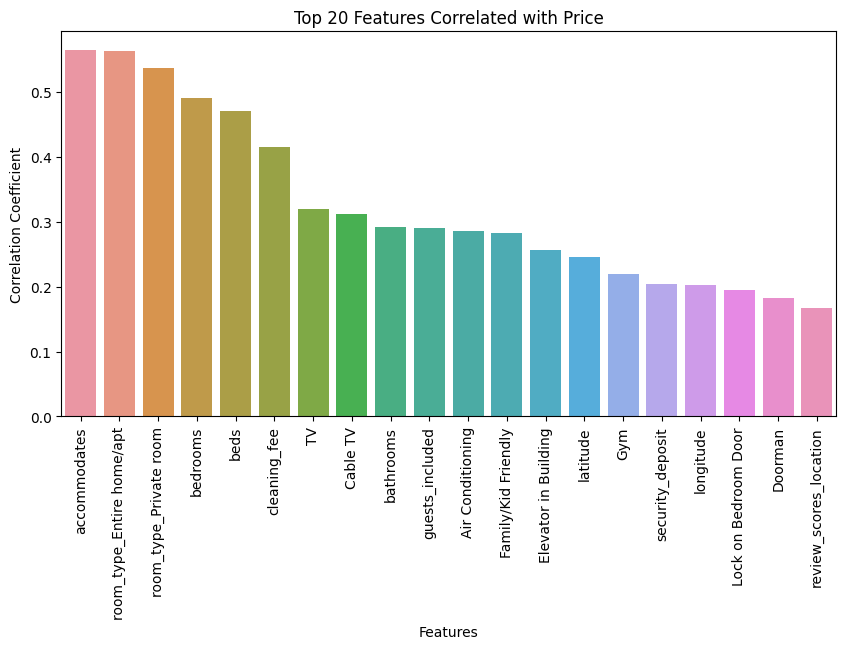

In [182]:
corr_matrix = df.corr()
corr_features = corr_matrix['price'].sort_values(ascending=False)
# absolute value of correlation coefficients
corr_features = corr_features.abs()
top_features = corr_features.nlargest(21)
top_features = top_features.drop('price')
print(top_features)

# plot the top 10 features
plt.figure(figsize=(10, 5))
plt.title('Top 20 Features Correlated with Price')
sns.barplot(x=top_features.index, y=top_features.values)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

## Train model

In [172]:
# Training
# 1. Load data

x = df.drop('price', axis=1)
y = df['price']

# 2. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=51)

# 3. Train the regression model with xgboost and hyperparameter tuning with RandomizedSearchCV
xgb_model = xgb.XGBRegressor()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5, 1],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 500],
    'colsample_bytree': [0.5, 0.7, 0.9, 1],
    'subsample': [0.5, 0.7, 0.9, 1],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}

xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=100, cv=5, verbose=2, random_state=51, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(xgb_random.best_params_)

xgb_final = xgb.XGBRegressor(**xgb_random.best_params_)
xgb_final.fit(X_train, y_train)

# 4. Evaluate the model
print("error score on test data: ", xgb_final.score(X_test, y_test))
# Accuracy:
print()

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 0.9}
error score on test data:  0.6607762449466242
